In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# file_path = '/content/drive/My Drive/cs131/mpii_human_pose.csv'

# with open(file_path, 'r') as file:
#     data = file.read()

In [18]:
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocess as mp
from sklearn.model_selection import train_test_split
from skimage import io, feature, data, color, exposure
# from preprocess_multi import *

# Read & Split Data

In [4]:
mpii_df = pd.read_csv('mpii_human_pose.csv')
mpii_numpy = mpii_df.to_numpy()

# print("DataFrame:")
# print(mpii_df.head())

print(f"\nData Shape: {mpii_numpy.shape}")
print(f"Num Unique Activities: {np.unique(mpii_numpy[:, -2]).shape}")


Data Shape: (17372, 37)
Num Unique Activities: (397,)


In [5]:
# Data split ratios
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Set seed for testing (TODO: Remove later)
seed = 42

# Randomize order of samples
indices = np.random.RandomState(seed=seed).permutation(len(mpii_numpy))
mpii_numpy_copy = mpii_numpy[indices]
category_labels = mpii_numpy[indices, -1]

# Split dataset
train_data, temp_data, train_labels, temp_labels = train_test_split(mpii_numpy_copy, category_labels,
                                                                    test_size=1-train_ratio, stratify=category_labels,
                                                                    random_state=seed)
validation_data, test_data, validation_labels, test_labels = train_test_split(temp_data,
                                                                              temp_labels,
                                                                              test_size=test_ratio/(test_ratio + validation_ratio),
                                                                              stratify=temp_labels,
                                                                              random_state=seed)

In [6]:
def resize_name(img_file: str) -> str:
  return img_file[:-4] + "_resized.png"

def get_img_file_path(img_file: str) -> str:
  return f"resized_images/{resize_name(img_file)}"

resized_images/001810944_resized.png


(-0.5, 1919.5, 1079.5, -0.5)

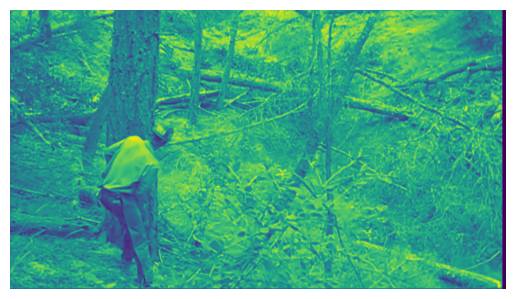

In [7]:
# Small test to make sure we have the right path
print(get_img_file_path(train_data[0][1]))
test_img = io.imread(get_img_file_path(train_data[0][1]), as_gray=True)
plt.imshow(test_img)
plt.axis('off')

# Process Data for Model

In [8]:
def hog_feature(image_path):
  image = io.imread(image_path, as_gray=True)
  pixel_per_cell = min(image.shape[0]/25, image.shape[1]/25)
  hog_feature = feature.hog(image, pixels_per_cell=(pixel_per_cell, pixel_per_cell),
                            block_norm='L2-Hys', feature_vector=True, transform_sqrt=True)
  return hog_feature

In [9]:
# Set feature_vector=False --> get (22, 42, 3, 3, 9)
hog_feature(get_img_file_path(train_data[0][1])).shape

(74844,)

In [32]:
# Really slow :(
def preprocess_data(data_set):
  X = []
  y = []

  for data_pt in data_set:
    img_file = get_img_file_path(data_pt[1])
    X.append(hog_feature(img_file))
    y.append(data_pt[2:-3])

  X = np.asarray(X)
  y = np.asarray(y)
  return X, y

In [31]:
def preprocess(data_pt):
  img_file = get_img_file_path(data_pt[1])
  X = hog_feature(img_file)
  y = data_pt[2:-3]
  return X, y, img_file

def parallel_preprocess(data_set):
  with mp.Pool() as pool:
    results = pool.map(preprocess, data_set)
  X, y, imgs = zip(*results)
  return np.array(X), np.array(y), np.array(imgs)

In [35]:
X_train, y_train, train_images = parallel_preprocess(train_data)

In [37]:
X_validation, y_validation, validation_images = parallel_preprocess(validation_data)

In [38]:
X_test, y_test, test_images = parallel_preprocess(test_data)

## Save data as files

In [36]:
np.save(f"processed_data/X_train.npy", X_train)
np.save(f"processed_data/y_train.npy", y_train)
np.save(f"processed_data/train_images.npy", train_images)

In [40]:
np.save(f"processed_data/X_validation.npy", X_validation)
np.save(f"processed_data/y_validation.npy", y_validation)
np.save(f"processed_data/validation_images.npy", validation_images)

In [42]:
np.save(f"processed_data/X_test.npy", X_test)
np.save(f"processed_data/y_test.npy", y_test)
np.save(f"processed_data/test_images.npy", test_images)

# Model Training

In [46]:
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_test.shape)
print(y_test.shape)

(13897, 74844)
(13897, 32)
(13897,)
(1737, 74844)
(1737, 32)
(1738, 74844)
(1738, 32)


In [51]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_validation = X_validation.astype(float)
y_validation = y_validation.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

In [68]:
NUM_FEATURES = X_train.shape[1]
def create_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation='tanh', input_shape=(input_shape,)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32)  # Output layer for 8 coordinates (2D)
    ])

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)  # Adjusted learning rate
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber())
    return model

def train_and_evaluate(epochs, batch_size):
    model = create_model(NUM_FEATURES)

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validation, y_validation))

    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)

    return model

In [69]:
trained_model = train_and_evaluate(10, 32)

Epoch 1/10
435/435 [==============================] - 15s 32ms/step - loss: 388.7013 - val_loss: 238.0501
Epoch 2/10
435/435 [==============================] - 9s 20ms/step - loss: 224.7910 - val_loss: 192.5575
Epoch 3/10
435/435 [==============================] - 9s 20ms/step - loss: 214.3313 - val_loss: 190.1725
Epoch 4/10
435/435 [==============================] - 9s 20ms/step - loss: 212.6953 - val_loss: 189.1170
Epoch 5/10
435/435 [==============================] - 9s 20ms/step - loss: 211.0423 - val_loss: 188.3924
Epoch 6/10
435/435 [==============================] - 9s 20ms/step - loss: 210.1054 - val_loss: 189.0427
Epoch 7/10
435/435 [==============================] - 9s 20ms/step - loss: 209.6024 - val_loss: 188.8377
Epoch 8/10
435/435 [==============================] - 10s 22ms/step - loss: 207.8710 - val_loss: 188.2557
Epoch 9/10
435/435 [==============================] - 9s 20ms/step - loss: 205.0538 - val_loss: 186.3943
Epoch 10/10
55/55 [==============================] - 

# Evaluation

In [54]:
def skeleton_lines(joints, color):
    plt.plot(np.append(joints[:3, 0], [joints[6, 0]]), np.append(joints[:3, 1], [joints[6, 1]]), color=color)  # Right leg
    plt.plot(np.append([joints[6, 0]], joints[3:6, 0]), np.append([joints[6, 1]], joints[3:6, 1]), color=color)  # Left leg
    plt.plot(joints[6:10, 0], joints[6:10, 1], color=color)
    plt.plot(np.append(joints[10:13, 0], [joints[7, 0]]), np.append(joints[10:13, 1], [joints[7, 1]]), color=color)  # Right arm
    plt.plot(np.append([joints[7, 0]], joints[13:, 0]), np.append([joints[7, 1]], joints[13:, 1]), color=color)  # Left arm

In [66]:
def get_original_image(img_file):
    return f"images/{img_file[15:-12]}.jpg"

55/55 [==============================] - 0s 7ms/step


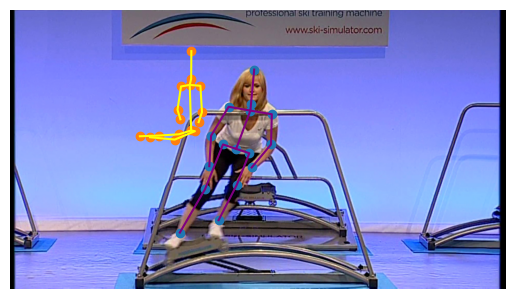

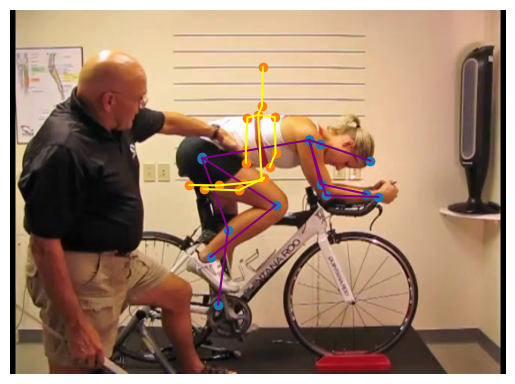

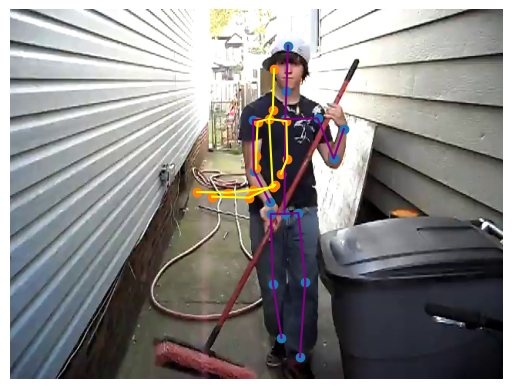

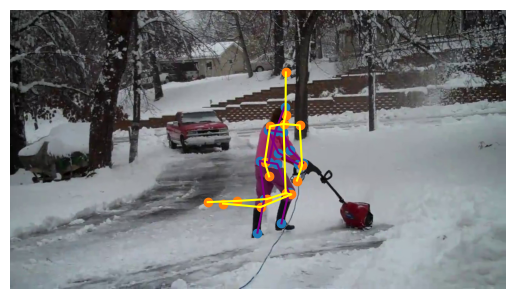

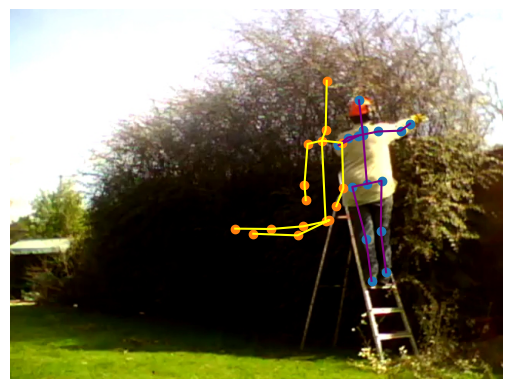

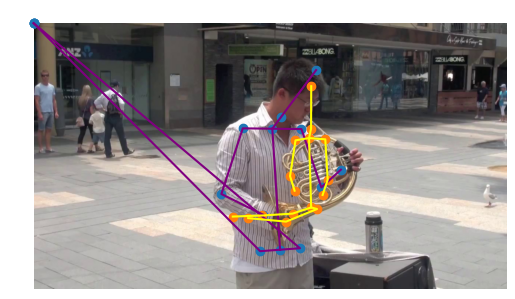

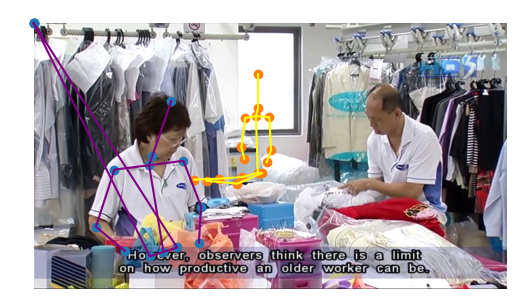

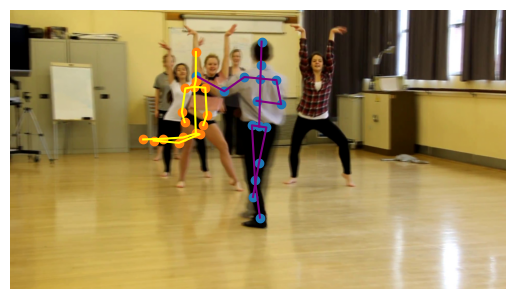

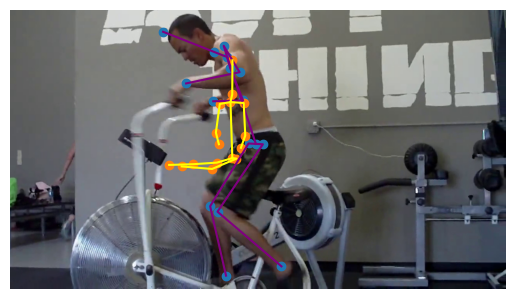

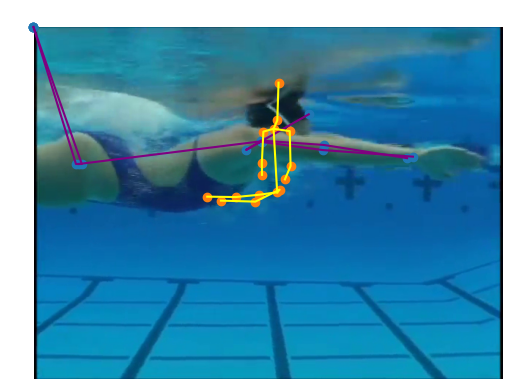

In [70]:
y_est = trained_model.predict(X_test)

for i in range(10):
    true_points = y_test[i].reshape((16, 2))
    est_points = y_est[i].reshape((16, 2))

    image = io.imread(get_original_image(test_images[i]))

    # Display the image using Matplotlib
    plt.imshow(image)
    plt.scatter(true_points[:, 0], true_points[:, 1])
    plt.scatter(est_points[:, 0], est_points[:, 1])
    skeleton_lines(true_points, "purple")
    skeleton_lines(est_points, "yellow")
    # plt.title('Your Image Title')
    plt.axis('off')  # Turn off axis labels
    plt.show()